In [1]:
import pandas as pd
from google.cloud import bigquery
import pandas_gbq
import os

# Set credentials for BigQuery client
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/sina/gradient-data/gcs_upload_key.json'

# Initialize BigQuery client
client = bigquery.Client(project='radicait')

print("=== BigQuery Dataset and Table Information ===")
print(f"Project: radicait")
print(f"Dataset: gradient_health_dataset") 
print(f"Table: public_table")
print()

# Get table schema/header information
table_ref = client.get_table('radicait.gradient_health_dataset.public_table')
print("=== Table Schema (Column Headers) ===")
print(f"Total columns: {len(table_ref.schema)}")
print()

# Display column information
for i, field in enumerate(table_ref.schema):
    print(f"{i+1:2d}. {field.name:<30} | {field.field_type:<15} | {field.mode}")

print()
print("=== Table Statistics ===")
print(f"Total rows: {table_ref.num_rows:,}")
print(f"Table size: {table_ref.num_bytes / (1024**3):.2f} GB")
print(f"Created: {table_ref.created}")
print(f"Modified: {table_ref.modified}")


=== BigQuery Dataset and Table Information ===
Project: radicait
Dataset: gradient_health_dataset
Table: public_table

=== Table Schema (Column Headers) ===
Total columns: 27

 1. row_id                         | BIGNUMERIC      | NULLABLE
 2. study_uid                      | STRING          | NULLABLE
 3. deid_english_report            | STRING          | NULLABLE
 4. imputed_ethnicity              | STRING          | NULLABLE
 5. imputed_race                   | STRING          | NULLABLE
 6. positive_entities              | STRING          | NULLABLE
 7. positive_entity_coordinates    | RECORD          | REPEATED
 8. snomed_tags                    | RECORD          | REPEATED
 9. on_demand_only                 | BOOLEAN         | NULLABLE
10. summary                        | STRING          | NULLABLE
11. patient_id                     | STRING          | NULLABLE
12. accession_number               | STRING          | NULLABLE
13. study_description              | STRING          | N

In [ ]:
# Query sample data from the table
print("=== Sample Data (df.head()) ===")
print("Querying first 5 rows from gradient_health_dataset...")
sample_query = """
SELECT
    count(distinct(study_uid)) as count_studies
FROM `radicait.gradient_health_dataset.public_table`,
UNNEST(series) AS series_item
WHERE series_item.modality = 'PT'
AND (
    REGEXP_CONTAINS(deid_english_report, r'(?i)lung cancer')
    OR REGEXP_CONTAINS(deid_english_report, r'(?i)pulmonary nodule')
)
"""

# Execute query and load into DataFrame using the existing BigQuery client
count = pandas_gbq.read_gbq(sample_query, project_id='radicait', location='us-central1', bigquery_client=client)
print("Number of records: ", count['count_studies'][0])

sample_query = """
SELECT
    CAST(row_id AS STRING) AS row_id,
    CAST(study_uid AS STRING) AS study_uid,
    patient_id,
    series_item.modality,
    series_item.acquisition_date,
    deid_english_report
FROM `radicait.gradient_health_dataset.public_table`,
UNNEST(series) AS series_item
WHERE series_item.modality = 'CT'
AND REGEXP_CONTAINS(deid_english_report, r'(?i)pulmonary nodule?')
LIMIT 50
"""

# Execute query and load into DataFrame using the existing BigQuery client
df_sample = pandas_gbq.read_gbq(sample_query, project_id='radicait', location='us-central1', bigquery_client=client)

print(f"DataFrame shape: {df_sample.shape}")
print()
print("=== DataFrame Info ===")
print(df_sample.info())
print()
print("=== DataFrame Head ===")
display(df_sample.head())


=== Sample Data (df.head()) ===
Querying first 5 rows from gradient_health_dataset...
Downloading: 100%|██████████|
Number of records:  8546
Downloading: 100%|██████████|
DataFrame shape: (50, 6)

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   row_id               50 non-null     object
 1   study_uid            50 non-null     object
 2   patient_id           50 non-null     object
 3   modality             50 non-null     object
 4   acquisition_date     43 non-null     dbdate
 5   deid_english_report  50 non-null     object
dtypes: dbdate(1), object(5)
memory usage: 2.5+ KB
None

=== DataFrame Head ===


,row_id,study_uid,patient_id,modality,acquisition_date,deid_english_report
0,229278212296906633189871921683055949599.266871...,1.2.826.0.1.3680043.8.498.51307770209376114167...,GRDNZXTEOTJBPCV8,CT,2025-05-18,Technique:\nVolumetric acquisitions with multi...
1,229278212296906633189871921683055949599.266871...,1.2.826.0.1.3680043.8.498.51307770209376114167...,GRDNZXTEOTJBPCV8,CT,2025-05-18,Technique:\nVolumetric acquisitions with multi...
2,229278212296906633189871921683055949599.266871...,1.2.826.0.1.3680043.8.498.51307770209376114167...,GRDNZXTEOTJBPCV8,CT,2025-05-18,Technique:\nVolumetric acquisitions with multi...
3,86041117762598086609270240211273349482.1662591...,1.2.826.0.1.3680043.8.498.67895587175460271253...,GRDN1IZ4XJH7WOWE,CT,NaT,CT Chest Lung Screen ...
4,51604994419465324061229539726917970547.1254015...,1.2.826.0.1.3680043.8.498.86075213045084522424...,GRDNSAME5GKRTBBI,CT,NaT,CTA Chest-PE ...


In [ ]:
# submit search query and build a table
import pandas as pd
from google.cloud import bigquery
import pandas_gbq
import os

# Set credentials for BigQuery client
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/sina/gradient-data/gcs_upload_key.json'

# Initialize BigQuery client
client = bigquery.Client(project='radicait')
search_terms = ['lung cancer', 'pulmonary nodule', 'lung nodule']
complete_df = pd.DataFrame()
for search_term in search_terms:
    with open('gradient_pt_ct_all_pairs_query.sql', 'r') as f:
        query = f.read()
    query = query.replace('<search_term>', search_term)
    df = pandas_gbq.read_gbq(query, project_id='radicait', location='us-central1', bigquery_client=client)
    print("Number of records: ", df.shape[0])
    complete_df = pd.concat([complete_df, df])
    # Deduplicate complete_df rows that have the same PET study_uid
    # Deduplicate by pt_study_uid and ct_study_uid, keeping the row with the smallest ct_slice_thickness
    complete_df = complete_df.drop_duplicates(subset=['ct_study_uid'])

# Save the complete_df to a csv file


Downloading: 100%|██████████|
Number of records:  5206
Downloading: 100%|██████████|
Number of records:  15604
Downloading: 100%|██████████|
Number of records:  4701


In [5]:
complete_df['combined_report'] = "#CT Report:\n" + complete_df['ct_report'] + "\n\n#PET Report:\n" + complete_df['pt_report']

In [6]:
print(f"Number of rows in complete_df: {len(complete_df)}")

Number of rows in complete_df: 25511


In [11]:
complete_df.to_csv('gradient_pt_ct_all_pairs_query.csv', index=False)

#### NOW RUN THE LLM EXTRACTION PIPELINE

# Processing Extracted Data

In [2]:
# Loading extracted data
import pandas as pd
extracted_data = pd.read_csv('extracted_report_CT_PET.csv')
extracted_data.head()

,pt_row_id,pt_study_uid,patient_id,pt_modality,pt_acquisition_date,pt_report,ct_study_uid,ct_acquisition_date,ct_report,ct_contrast_agent,...,ct_contrast_agent_extracted,lung_nodules,lung_hypermetabolic,lymph_nodes_hypermetabolic,other_hypermetabolic,pet_tracer,pet_scan_region,pet_blood_glucose_level,pet_waiting_time,success
0,249325815826495568736261472960528876645.470977...,1.2.826.0.1.3680043.8.498.72508264654538970259...,GRDN00BV4E3TW9C3,PT,2007-07-20,Clinical Data: Right lung mass. No reported hi...,1.2.826.0.1.3680043.8.498.35734528491551972864...,2007-06-28,Clinical Data: Subarachnoid intracranial hem...,NaN,...,NaN,"[{""size_mm"": ""27"", ""location"": ""right lower lo...","[{""size_mm"": ""27"", ""location"": ""right lower lo...",[],[],16.0 mCi F-18 FDG,skull base to mid-thighs,114 mg/dL,87 min,True
1,90462933703924279048684369271325482137.9847018...,1.2.826.0.1.3680043.8.498.76442354759882531644...,GRDN00HDHRSFFZUF,PT,2013-02-19,*RADIOLOGY REPORT*\n\nClinical Data: Subsequen...,1.2.826.0.1.3680043.8.498.70478005265243780429...,2013-02-15,*RADIOLOGY REPORT*\n\nClinical Data: Pneumonia...,NaN,...,NaN,"[{""size_mm"": ""57"", ""location"": ""right upper lo...","[{""size_mm"": """", ""location"": ""right upper lobe...","[{""size_mm"": ""14"", ""location"": ""mediastinal"", ...",[],16.1 mCi GUMA18 FDG,skull base to thigh,198 mg/dL,61 min,True
2,138821356403502744133274257961611282269.237009...,1.2.826.0.1.3680043.8.498.98076420036417325969...,GRDN00HDHRSFFZUF,PT,2006-03-10,Clinical Data: Left upper lobe mass. \n\nFDG ...,1.2.826.0.1.3680043.8.498.43175042184015050635...,2006-01-24,Clinical data: Shortness of breath; evaluat...,NaN,...,NaN,"[{""size_mm"": ""23"", ""location"": ""left lower lob...","[{""size_mm"": """", ""location"": ""left upper lobe""...","[{""size_mm"": """", ""location"": ""mediastinal"", ""S...","[{""size_mm"": """", ""location"": ""colon"", ""SUV"": ""...",14.5 mCi F-18 FDG,skull base to mid-thighs,79,65 min,True
3,88885770256518919607265168982243116832.1246588...,1.2.826.0.1.3680043.8.498.81026499077716957976...,GRDN01GKK1RQ23T5,PT,2014-09-30,CLINICAL DATA: Subsequent treatment strategy ...,1.2.826.0.1.3680043.8.498.56522776611923071280...,2014-09-06,CLINICAL DATA: Follow up lung cancer diagnose...,NaN,...,NaN,"[{""size_mm"": ""36"", ""location"": """", ""Slice_numb...","[{""size_mm"": """", ""location"": ""left upper lobe""...",[],[],18.4 mCi F-18 FDG,skull base to thigh,92mg/dl,NaN,True
4,188951894571408614310666009531592326291.239161...,1.2.826.0.1.3680043.8.498.76274378682571862313...,GRDN03JKBGJJ35Y4,PT,2018-05-06,CLINICAL DATA: Initial treatment strategy for...,1.2.826.0.1.3680043.8.498.10589814052322793053...,2018-03-24,"CLINICAL DATA: Chest pain question effusion, ...",NaN,...,NaN,"[{""size_mm"": ""44"", ""location"": ""right lower lo...","[{""size_mm"": ""40"", ""location"": ""right lower lo...",[],"[{""size_mm"": """", ""location"": ""soft tissue"", ""S...",6.9 mCi PINK18 FDG,skull base to thigh,146 mg/dl,NaN,True


In [3]:
#Subset studies with the following criteria:
# 1. ct_regions has string "chest"
# 2. primary_diagnosis  is Primary Lung Cancer
# 3. lung_nodules is not "[]"
# 4. lymph_nodes_hypermetabolic is "[]"
# 5. other_hypermetabolic is "[]"

selected_studies = extracted_data[
    (extracted_data['ct_regions'].str.contains('chest', na=False)) & 
    (extracted_data['primary_diagnosis'] == 'Primary Lung Cancer') & 
    (extracted_data['lung_nodules'] != '[]') & 
    (extracted_data['lymph_nodes_hypermetabolic'] == '[]') & 
    (extracted_data['other_hypermetabolic'] == '[]')
]

print(f"Selected {len(selected_studies)} studies out of {len(extracted_data)} total studies")
selected_studies.to_csv('selected_PET_CT_studies.csv', index=False)

Selected 780 studies out of 5793 total studies


In [10]:
import firebase_admin
from firebase_admin import credentials, firestore

# Path to your Firebase credentials (update if needed)
CREDENTIALS_PATH = "/home/sina/gradient-data/gcs_upload_key.json"

# Initialize Firebase app if not already initialized
if not firebase_admin._apps:
    cred = credentials.Certificate(CREDENTIALS_PATH)
    firebase_admin.initialize_app(cred)

db = firestore.client()

# Read all documents from the 'studies' collection and collect 'row_id' fields
previous_row_ids = []
docs = db.collection('studies').stream()
for doc in docs:
    data = doc.to_dict()
    if 'row_id' in data:
        previous_row_ids.append(data['row_id'])

print("previous_row_ids:", previous_row_ids)



previous_row_ids: ["'154619030048237415015444380605470266899.11405280048981458297153142075271696297", "'94651146599917294709273569366678389337.69384993562427136876091746699944675167", "'226639211269847640431074645995661572091.67594372999375074645565444935977084239", "'37603182229707862624914699947268591645.6377210962661256938801701140715170695", "'116653851785241903239637895944809119214.17238516052554091488090836714509976042", "'207360966009807705856526204030423833462.11228586351831831542128471161853304886", "'294289435496762725698999949841131734483.23420778286820139388228154691727190618", "'181210292568358319455925230152130195481.84342397548003651611569429491216771243", "'71066441081471402296414480240463614242.9448789689883812487393170034458516081", "'92077903340866861353138606183466244836.99530387756939070031902321635840485532", "'53080511393626668492661895724484588706.29524673140308030061617095329766304971", "'146493876851430030659586550150039116188.903062130223574119035080368143565

In [4]:
previous_row_ids[1]
# Remove leading single quote from each element in previous_row_ids, if present
previous_row_ids = [rid[1:] if isinstance(rid, str) and rid.startswith("'") else rid for rid in previous_row_ids]
previous_row_ids[1]


'94651146599917294709273569366678389337.69384993562427136876091746699944675167'

In [5]:
ct_study_id = selected_studies['ct_study_uid'].tolist()
pt_study_id = selected_studies['pt_study_uid'].tolist()

# determine pt_study_uids that have the same row_id as the previous_row_ids
# Select pt_study_uid where associated pt_row_id is not in previous_row_ids
new_pt_studies = selected_studies[~selected_studies['pt_row_id'].isin(previous_row_ids)]
new_pt_study_uids = new_pt_studies['pt_study_uid'].tolist()

print(f"Number of new pt_study_uids not in previous_row_ids: {len(new_pt_study_uids)}")

combined_study_ids = ct_study_id + new_pt_study_uids

print(f"Number of combined study ids: {len(combined_study_ids)}")
import pandas as pd
pd.Series(combined_study_ids).to_csv('PET_CT_study_ids.csv', index=False, header=False)








Number of new pt_study_uids not in previous_row_ids: 655
Number of combined study ids: 1435


In [11]:
subset_extracted_data = extracted_data[extracted_data['ct_study_uid'].isin(ct_study_id)]


In [6]:
# Some info from the gradient csv they sent us
import pandas as pd
gradient_report = pd.read_csv('/home/sina/Data/Gradient/PET_CT_30JUN2025-R1/CSV/dicom_metadata000000000000.csv')
gradient_report.head()
print("Columns in gradient_report:")
print(gradient_report.columns.tolist())


Columns in gradient_report:
['AccessionNumber', 'AcquisitionDate', 'AcquisitionDateTime', 'BitsAllocated', 'BitsStored', 'BodyPartExamined', 'BolusDescription', 'ContrastBolusAgent', 'CountryOfResidence', 'EthnicGroup', 'GantryDetectorTilt', 'HighBit', 'InstitutionName', 'KVP', 'Laterality', 'MagneticFieldStrength', 'Manufacturer', 'ManufacturerModelName', 'Modality', 'PatientAge', 'PatientBirthDate', 'PatientID', 'PatientSex', 'PatientSize', 'PatientWeight', 'PhotometricInterpretation', 'PixelAspectRatio', 'PixelRepresentation', 'PixelSpacing', 'ProtocolName', 'Rows', 'SamplesPerPixel', 'SeriesDate', 'SeriesDescription', 'SeriesInstanceUid', 'SliceThickness', 'SmokingStatus', 'SpatialResolution', 'StudyDate', 'StudyDescription', 'StudyID', 'StudyInstanceUid']


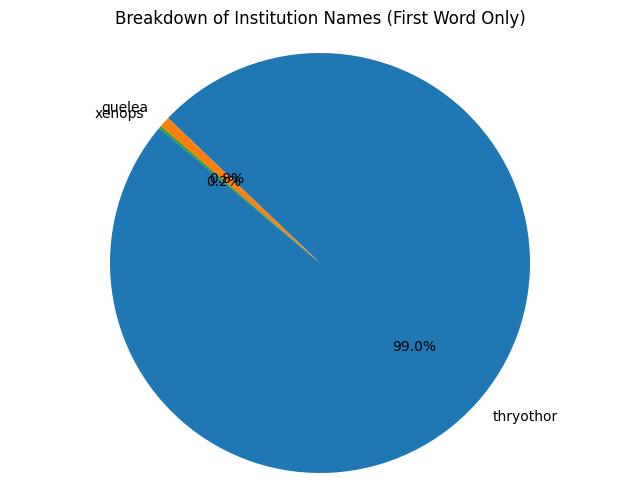

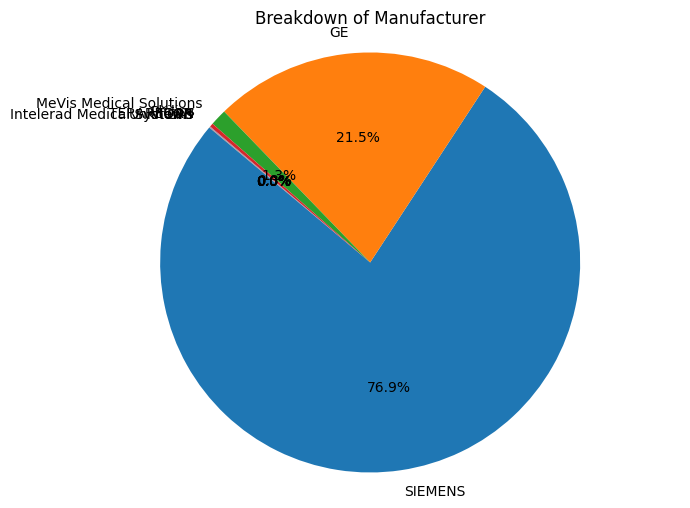

In [10]:
import matplotlib.pyplot as plt

# Extract only the first word from each InstitutionName
first_word_institution = gradient_report['InstitutionName'].astype(str).str.split('-').str[0]
institution_counts = first_word_institution.value_counts()

plt.figure(figsize=(8, 6))
plt.pie(institution_counts, labels=institution_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Breakdown of Institution Names (First Word Only)')
plt.axis('equal')
plt.show()

# Pie chart for 'Manufacturer' column
if 'Manufacturer' in gradient_report.columns:
    manufacturer_counts = gradient_report['Manufacturer'].value_counts()
    plt.figure(figsize=(8, 6))
    plt.pie(manufacturer_counts, labels=manufacturer_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Breakdown of Manufacturer')
    plt.axis('equal')
    plt.show()
else:
    print("Column 'manufacturer' not found in gradient_report.")
